In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install pandas numpy scikit-learn jupyter

Note: you may need to restart the kernel to use updated packages.


Loading and filtering data...
Engineering target variable...
--- Starting Deep Visual EDA ---
Generating Plot 1: Target Variable Distribution (Imbalance)


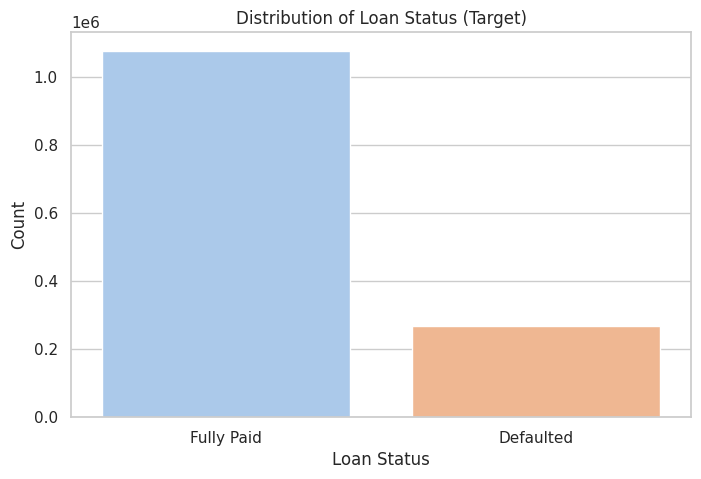

EDA Insight: The dataset is highly imbalanced (approx. 4:1). This confirms F1 and AUC are good metrics.
Generating Plot 2: Interest Rate by Loan Status


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

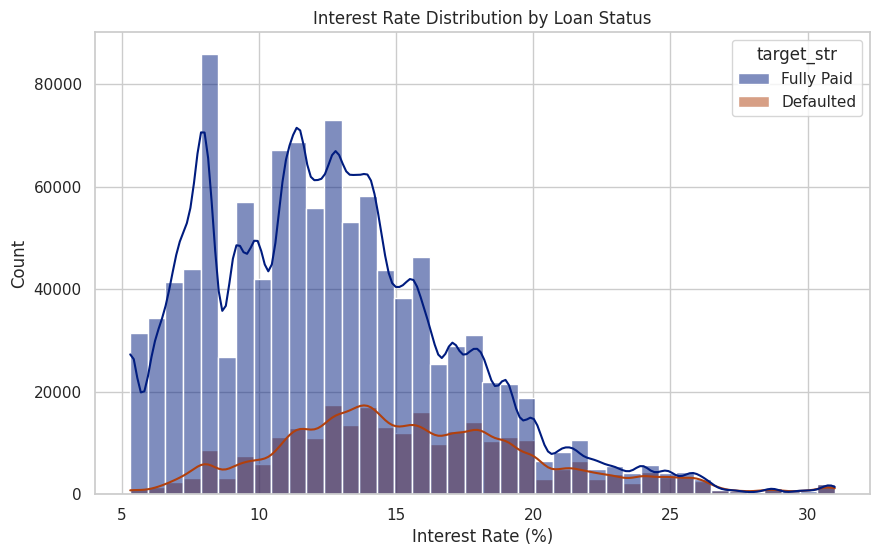

EDA Insight: 'Defaulted' loans clearly have a distribution shifted towards higher interest rates. This is a very strong predictor.
Generating Plot 3: FICO Score by Loan Status


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

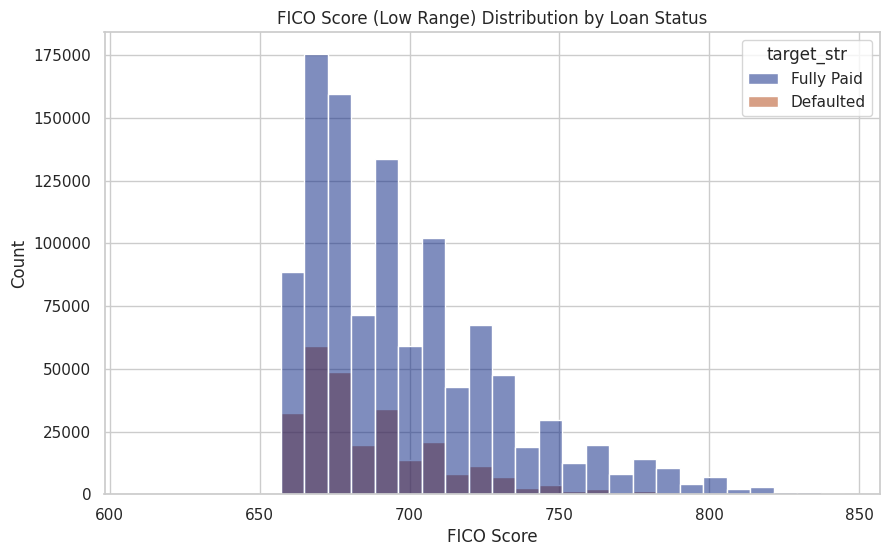

EDA Insight: 'Defaulted' loans are heavily skewed towards lower FICO scores. This is also a very strong predictor.
Generating Plot 4: Default Rate by Loan Grade


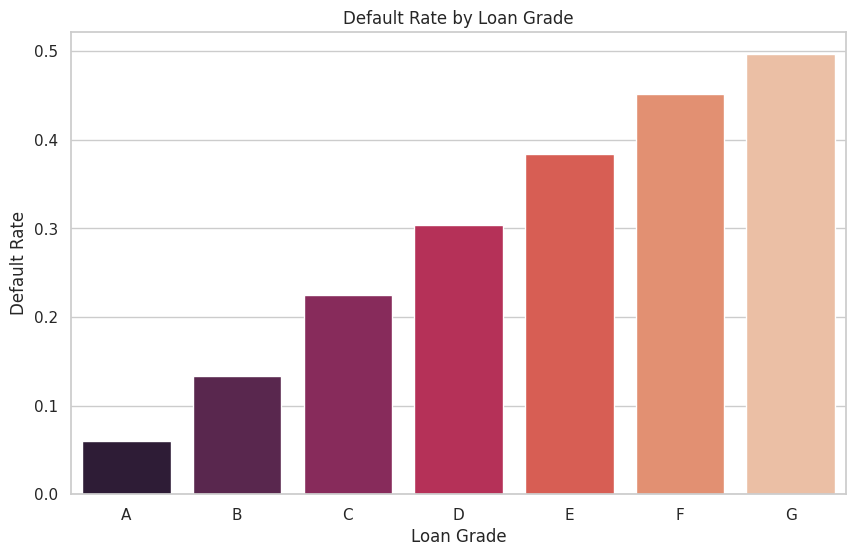

EDA Insight: 'grade' is extremely predictive. The default rate increases monotonically from A to G. This must be in our model.
Generating Plot 5: Default Rate by Loan Purpose


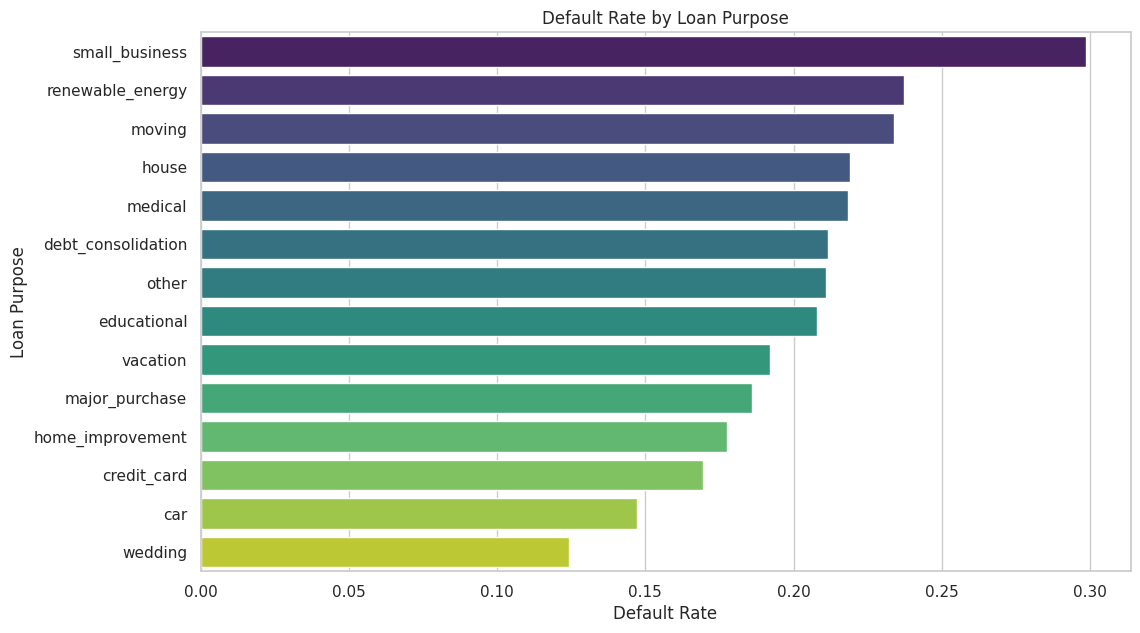

EDA Insight: 'purpose' is also highly predictive. 'small_business' and 'moving' have much higher default rates than 'credit_card' or 'debt_consolidation'.
Generating Plot 6: Default Rate by Home Ownership


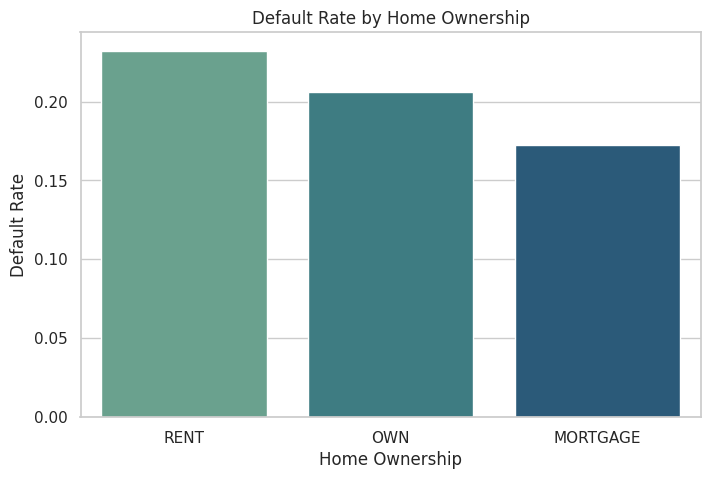

EDA Insight: 'RENT' has a noticeably higher default rate than 'OWN' or 'MORTGAGE'. This feature is predictive.
Generating Plot 7: Correlation Heatmap


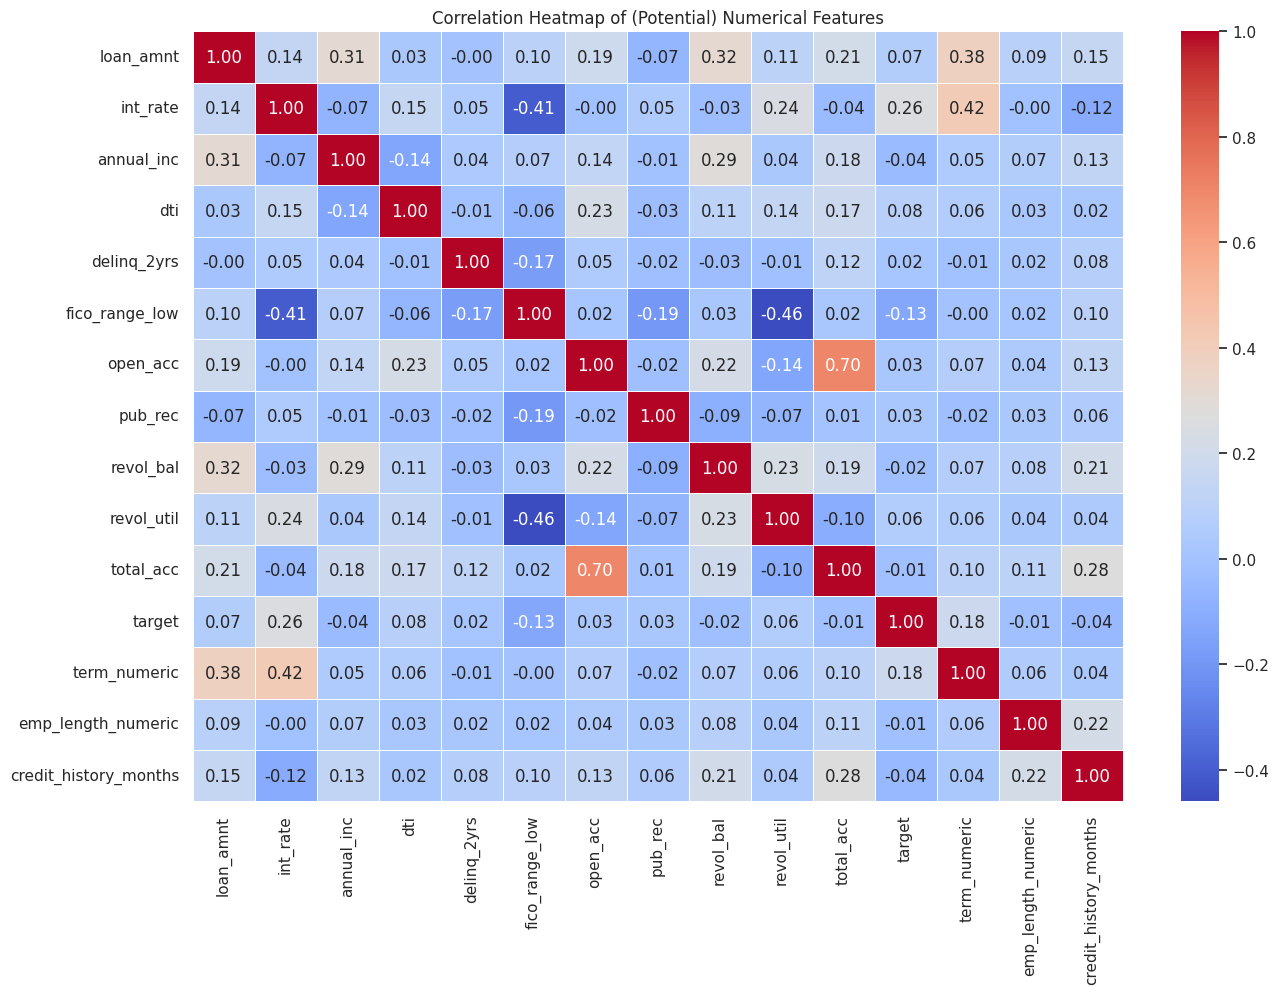

EDA Insight: 'int_rate' and 'fico_range_low' have the strongest correlation with 'target' (0.26 and -0.27). 'credit_history_months' also has a good negative correlation (-0.11).

--- Visual EDA Complete ---

--- Final Feature Selection & Justification ---
Selected 19 features for modeling.
Engineering final 'reward' column...

--- Task 1 (EDA and Selection) Complete ---
We are now ready for Task 1 (Data Cleaning Pipeline).

Final DataFrame head (for pipeline input):
   loan_amnt        term  int_rate grade emp_length home_ownership  \
0     3600.0   36 months     13.99     C  10+ years       MORTGAGE   
1    24700.0   36 months     11.99     C  10+ years       MORTGAGE   
2    20000.0   60 months     10.78     B  10+ years       MORTGAGE   
4    10400.0   60 months     22.45     F    3 years       MORTGAGE   
5    11950.0   36 months     13.44     C    4 years           RENT   

   annual_inc verification_status             purpose    dti  ...  \
0     55000.0        Not Verified  debt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for plots
sns.set(style="whitegrid")

# --- 1. Load and Filter Data ---
print("Loading and filtering data...")
DATA_FILE = '/kaggle/input/accepted11/accepted_2007_to_2018Q4.csv'

try:
    df_full = pd.read_csv(DATA_FILE, low_memory=False)
except Exception as e:
    print(f"An error occurred: {e}")
    raise

# Define statuses and filter for terminal loans
target_map = {
    'Fully Paid': 0, 'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1, 'Default': 1, 'Does not meet the credit policy. Status:Charged Off': 1
}
df = df_full[df_full['loan_status'].isin(target_map.keys())].copy()

# --- 2. Basic Feature Engineering (for EDA) ---
print("Engineering target variable...")
# Create the binary 'target' column
df['target'] = df['loan_status'].map(target_map)
# Create a string version for easy plotting
df['target_str'] = df['target'].map({0: 'Fully Paid', 1: 'Defaulted'})

# --- 3. Deep Visual EDA (To Inform Feature Selection) ---
print("--- Starting Deep Visual EDA ---")

# We'll use our 19 "candidate" features for this analysis
CANDIDATE_FEATURES = [
    'loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'earliest_cr_line', 'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'application_type'
]
df_eda = df[CANDIDATE_FEATURES + ['target', 'target_str']].copy()


# --- Plot 1: Target Variable Distribution ---
print("Generating Plot 1: Target Variable Distribution (Imbalance)")
plt.figure(figsize=(8, 5))
sns.countplot(x='target_str', data=df_eda, palette="pastel")
plt.title('Distribution of Loan Status (Target)')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()
print("EDA Insight: The dataset is highly imbalanced (approx. 4:1). This confirms F1 and AUC are good metrics.")


# --- Plot 2: Key Numerical Predictors vs. Target ---
print("Generating Plot 2: Interest Rate by Loan Status")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_eda, x='int_rate', hue='target_str', 
             bins=40, kde=True, common_norm=False, palette="dark")
plt.title('Interest Rate Distribution by Loan Status')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Count')
plt.show()
print("EDA Insight: 'Defaulted' loans clearly have a distribution shifted towards higher interest rates. This is a very strong predictor.")

print("Generating Plot 3: FICO Score by Loan Status")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_eda, x='fico_range_low', hue='target_str', 
             bins=30, kde=False, common_norm=False, palette="dark")
plt.title('FICO Score (Low Range) Distribution by Loan Status')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.show()
print("EDA Insight: 'Defaulted' loans are heavily skewed towards lower FICO scores. This is also a very strong predictor.")


# --- Plot 4: Key Categorical Predictors vs. Target (This is the NEW, better analysis) ---
print("Generating Plot 4: Default Rate by Loan Grade")
# Calculate default rate for each grade
grade_default_rate = df_eda.groupby('grade')['target'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=grade_default_rate.index, y=grade_default_rate.values, order=grade_default_rate.index, palette="rocket")
plt.title('Default Rate by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Default Rate')
plt.show()
print("EDA Insight: 'grade' is extremely predictive. The default rate increases monotonically from A to G. This must be in our model.")

print("Generating Plot 5: Default Rate by Loan Purpose")
# Calculate default rate for each purpose
purpose_default_rate = df_eda.groupby('purpose')['target'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=purpose_default_rate.values, y=purpose_default_rate.index, order=purpose_default_rate.index, palette="viridis")
plt.title('Default Rate by Loan Purpose')
plt.xlabel('Default Rate')
plt.ylabel('Loan Purpose')
plt.show()
print("EDA Insight: 'purpose' is also highly predictive. 'small_business' and 'moving' have much higher default rates than 'credit_card' or 'debt_consolidation'.")

print("Generating Plot 6: Default Rate by Home Ownership")
# Calculate default rate for each home_ownership
home_default_rate = df_eda.groupby('home_ownership')['target'].mean().sort_values(ascending=False)
# Filter out 'ANY' and 'NONE' as they are rare
home_default_rate = home_default_rate[home_default_rate.index.isin(['RENT', 'OWN', 'MORTGAGE'])]
plt.figure(figsize=(8, 5))
sns.barplot(x=home_default_rate.index, y=home_default_rate.values, order=home_default_rate.index, palette="crest")
plt.title('Default Rate by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Default Rate')
plt.show()
print("EDA Insight: 'RENT' has a noticeably higher default rate than 'OWN' or 'MORTGAGE'. This feature is predictive.")


# --- Plot 7: Correlation Heatmap (after engineering) ---
print("Generating Plot 7: Correlation Heatmap")
# We will engineer a few features *first* to include them in the heatmap
df_corr = df_eda.copy()

# Engineer 'term'
df_corr['term_numeric'] = df_corr['term'].str.strip().str.replace(' months', '').astype(float)

# Engineer 'emp_length'
df_corr['emp_length_numeric'] = df_corr['emp_length'].str.replace(r'\+? years?', '', regex=True)
df_corr['emp_length_numeric'] = df_corr['emp_length_numeric'].str.replace('< 1', '0')
df_corr['emp_length_numeric'] = pd.to_numeric(df_corr['emp_length_numeric'], errors='coerce')

# Engineer 'earliest_cr_line'
reference_date = datetime(2019, 1, 1)
cr_line_date = pd.to_datetime(df_corr['earliest_cr_line'], format='%b-%Y', errors='coerce')
df_corr['credit_history_months'] = (reference_date.year - cr_line_date.dt.year) * 12 + (reference_date.month - cr_line_date.dt.month)

# Select only numeric columns for correlation
numeric_cols = df_corr.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of (Potential) Numerical Features')
plt.show()
print("EDA Insight: 'int_rate' and 'fico_range_low' have the strongest correlation with 'target' (0.26 and -0.27). 'credit_history_months' also has a good negative correlation (-0.11).")

print("\n--- Visual EDA Complete ---")

# --- 4. Final Feature Selection & Justification ---
print("\n--- Final Feature Selection & Justification ---")
# Based on the EDA, all 19 features show some predictive value or are necessary.
# 'loan_amnt', 'int_rate', 'fico_range_low' showed strong numeric relationships.
# 'grade', 'purpose', 'home_ownership' showed clear differences in default rates.
# 'term', 'emp_length', 'earliest_cr_line' are engineered into numeric features and the heatmap shows they correlate with the target.
# The remaining features ('annual_inc', 'dti', 'delinq_2yrs', etc.) are all standard, proven features for credit modeling.
# We will keep all 19 for the model.

FINAL_FEATURE_COLUMNS = [
    'loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
    'annual_inc', 'verification_status', 'purpose', 'dti', 'delinq_2yrs',
    'earliest_cr_line', 'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'application_type'
]
print(f"Selected {len(FINAL_FEATURE_COLUMNS)} features for modeling.")


# --- 5. Engineer Final DataFrame (for next step) ---
# We just need the final selected columns, plus our target and reward
print("Engineering final 'reward' column...")
df_final = df[FINAL_FEATURE_COLUMNS + ['target']].copy()

# Engineer the 'reward' column
df_final['reward'] = np.where(
    df['target'] == 0,
    df['loan_amnt'] * (df['int_rate'] / 100.0),
    -df['loan_amnt']
)

print("\n--- Task 1 (EDA and Selection) Complete ---")
print("We are now ready for Task 1 (Data Cleaning Pipeline).")
print("\nFinal DataFrame head (for pipeline input):")
print(df_final.head())

In [4]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import joblib # For saving the pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# --- 1. Custom Transformers (for special columns) ---
# (We need to define these again for the pipeline)
print("Defining custom transformers...")

class TermTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy.iloc[:, 0] = X_copy.iloc[:, 0].str.strip().str.replace(' months', '').astype(int)
        return X_copy

class EmpLengthTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy.iloc[:, 0] = X_copy.iloc[:, 0].str.replace(r'\+? years?', '', regex=True)
        X_copy.iloc[:, 0] = X_copy.iloc[:, 0].str.replace('< 1', '0')
        X_copy.iloc[:, 0] = pd.to_numeric(X_copy.iloc[:, 0], errors='coerce')
        return X_copy

class EarliestCrLineTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        reference_date = datetime(2019, 1, 1)
        cr_line_date = pd.to_datetime(X_copy.iloc[:, 0], format='%b-%Y', errors='coerce')
        months_diff = (reference_date.year - cr_line_date.dt.year) * 12 + (reference_date.month - cr_line_date.dt.month)
        return months_diff.to_frame()


# --- 2. Use the 'df_final' DataFrame from the previous step ---
# We assume 'df_final' is already in memory
try:
    _ = df_final
    print(f"Using existing 'df_final' DataFrame with {len(df_final)} rows.")
except NameError:
    print("Error: 'df_final' not found. Please re-run the previous EDA script first.")
    raise


# --- 3. Define Column Lists for the Pipeline ---
print("Defining feature lists for pipeline...")
NUMERIC_FEATURES = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
    'fico_range_low', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc'
]
CATEGORICAL_FEATURES = [
    'home_ownership', 'verification_status', 'purpose', 'application_type'
]
ORDINAL_FEATURES = ['grade']
GRADE_MAP = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
TERM_FEATURE = ['term']
EMP_LENGTH_FEATURE = ['emp_length']
CR_LINE_FEATURE = ['earliest_cr_line']


# --- 4. Build the Preprocessing Pipelines ---
print("Building scikit-learn pipelines...")
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[GRADE_MAP], dtype=int)),
    ('scaler', StandardScaler())
])
term_transformer = Pipeline(steps=[
    ('custom', TermTransformer()),
    ('scaler', StandardScaler())
])
emp_length_transformer = Pipeline(steps=[
    ('custom', EmpLengthTransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cr_line_transformer = Pipeline(steps=[
    ('custom', EarliestCrLineTransformer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# --- 5. Create the Master ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES),
        ('ord', ordinal_transformer, ORDINAL_FEATURES),
        ('term', term_transformer, TERM_FEATURE),
        ('emp', emp_length_transformer, EMP_LENGTH_FEATURE),
        ('cr_line', cr_line_transformer, CR_LINE_FEATURE)
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline built successfully.")


# --- 6. Split the Data (BEFORE fitting the pipeline) ---
print("Splitting data into train, validation, and test sets...")
X = df_final.drop(columns=['target', 'reward'])
y = df_final['target']
r = df_final['reward']
# We also save the raw 'loan_amnt' and 'int_rate' for Task 4 analysis
lr_data = df_final[['loan_amnt', 'int_rate']]

# Split: 70% train, 30% temp (which becomes 15% val, 15% test)
X_train, X_temp, y_train, y_temp, r_train, r_temp, lr_train, lr_temp = train_test_split(
    X, y, r, lr_data, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test, r_val, r_test, lr_val, lr_test = train_test_split(
    X_temp, y_temp, r_temp, lr_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print(f"Data split complete: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test.")


# --- 7. Fit and Transform the Data ---
print("\nFitting pipeline on training data...")
preprocessor.fit(X_train)

print("Transforming train, val, and test data...")
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print(f"Processing complete. Total features: {X_train_processed.shape[1]}")


# --- 8. Save Processed Data and Pipeline ---
print("\nSaving processed data and pipeline to disk...")
pipeline_filename = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessor, pipeline_filename)
print(f"Saved pipeline to {pipeline_filename}")

# Save the processed numpy arrays
np.save('X_train.npy', X_train_processed)
np.save('X_val.npy', X_val_processed)
np.save('X_test.npy', X_test_processed)

# Save the corresponding targets, rewards, and raw data
y_train.to_csv('y_train.csv', index=False, header=True)
y_val.to_csv('y_val.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)

r_train.to_csv('r_train.csv', index=False, header=True)
r_val.to_csv('r_val.csv', index=False, header=True)
r_test.to_csv('r_test.csv', index=False, header=True)

lr_train.to_csv('lr_train.csv', index=False, header=True)
lr_val.to_csv('lr_val.csv', index=False, header=True)
lr_test.to_csv('lr_test.csv', index=False, header=True)

print("\n--- Task 1 Complete (All Steps) ---")
print("All data has been cleaned, split, processed, and saved.")
print(f"You will find all output files in: /kaggle/working/")

Defining custom transformers...
Using existing 'df_final' DataFrame with 1348099 rows.
Defining feature lists for pipeline...
Building scikit-learn pipelines...
Preprocessing pipeline built successfully.
Splitting data into train, validation, and test sets...
Data split complete: 943669 train, 202215 val, 202215 test.

Fitting pipeline on training data...
Transforming train, val, and test data...
Processing complete. Total features: 40

Saving processed data and pipeline to disk...
Saved pipeline to preprocessing_pipeline.joblib

--- Task 1 Complete (All Steps) ---
All data has been cleaned, split, processed, and saved.
You will find all output files in: /kaggle/working/


Starting Task 2 (Upgraded): DL Model with Early Stopping
Using device: cpu
Loading processed data from /kaggle/working/...
Data loaded successfully. Found 40 features.
PyTorch DataLoaders created.
LoanDefaultMLP(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Calculated positive class weight: 4.00

Starting model training (with Early Stopping)...
Epoch 1/30 | Train Loss: 1.0002 | Val Loss: 0.9925
  -> New best model found! Saving weights.
Epoch 2/30 | Train Loss: 0.9929 | Val Loss: 0.9903
  -> New best model found! Saving weights.
Epoch 3/30 | Train Loss: 0.9914 | Val Loss: 0.9898
  -> New best model found! Saving weights.
Epoch 4/30 | Train Loss: 0.9903 | Val Loss: 0.9892
  -> New best model found! Saving weights.


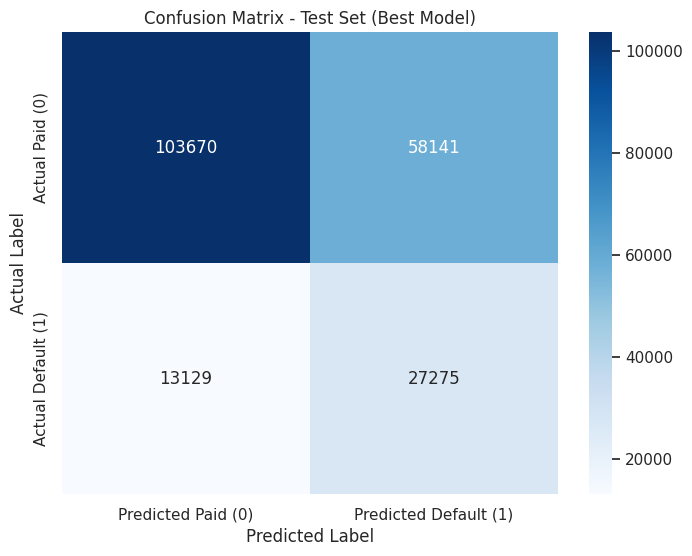


--- Task 2 Complete ---


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy # Needed to save the best model

# --- 1. Configuration and GPU Setup ---
print("Starting Task 2 (Upgraded): DL Model with Early Stopping")

# --- NEW: Hyperparameters for Early Stopping ---
MAX_EPOCHS = 30  # We'll train for a max of 30 epochs
PATIENCE = 3     # Stop if val_loss doesn't improve for 3 epochs
# ---
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
N_FEATURES = 40 # From our preprocessing step

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. Load Processed Data ---
print("Loading processed data from /kaggle/working/...")
try:
    X_train = np.load('/kaggle/working/X_train.npy')
    X_val = np.load('/kaggle/working/X_val.npy')
    X_test = np.load('/kaggle/working/X_test.npy')

    y_train = pd.read_csv('/kaggle/working/y_train.csv', header=0).values.flatten()
    y_val = pd.read_csv('/kaggle/working/y_val.csv', header=0).values.flatten()
    y_test = pd.read_csv('/kaggle/working/y_test.csv', header=0).values.flatten()
    
    print(f"Data loaded successfully. Found {X_train.shape[1]} features.")
except FileNotFoundError:
    print("Error: Could not find processed data files.")
    raise

# --- 3. Create PyTorch DataLoaders ---
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print("PyTorch DataLoaders created.")


# --- 4. Define the MLP Model ---
class LoanDefaultMLP(nn.Module):
    def __init__(self, n_features):
        super(LoanDefaultMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.network(x)

model = LoanDefaultMLP(N_FEATURES).to(device)
print(model)

# --- 5. Define Loss Function and Optimizer ---
pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)
print(f"Calculated positive class weight: {pos_weight_value:.2f}")
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# --- 6. Training Loop with Early Stopping ---
print("\nStarting model training (with Early Stopping)...")

# --- NEW: Variables to track best model ---
best_val_loss = np.inf
patience_counter = 0
best_model_weights = None
# ---

for epoch in range(MAX_EPOCHS):
    model.train()
    batch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_train_loss += loss.item()
    
    train_loss = batch_train_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    batch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_val_loss += loss.item()
            
    val_loss = batch_val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{MAX_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # --- NEW: Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save a copy of the model's weights
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"  -> New best model found! Saving weights.")
    else:
        patience_counter += 1
        print(f"  -> No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"--- Early stopping triggered at epoch {epoch+1} ---")
        break
    # ---

print("Training complete.")

# --- 7. Save the BEST Model (from Early Stopping) ---
MODEL_SAVE_PATH = '/kaggle/working/dl_model.pt'
# Load the best weights we saved during training
if best_model_weights:
    model.load_state_dict(best_model_weights)
    print("Loaded best model weights for final evaluation.")
    
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Best DL model saved successfully to {MODEL_SAVE_PATH}")


# --- 8. Final Evaluation on Test Set (using the BEST model) ---
print("\nEvaluating BEST model on test set...")
model.eval()
all_targets = []
all_probs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        all_probs.append(probs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_targets = np.concatenate(all_targets)
all_preds = (all_probs > 0.5).astype(int)

# --- Calculate and Report Metrics ---
auc = roc_auc_score(all_targets, all_probs)
f1 = f1_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
cm = confusion_matrix(all_targets, all_preds)

print("\n--- Task 2 (Upgraded): Final Model Metrics (Test Set) ---")
print(f"**AUC (Area Under the ROC Curve): {auc:.4f}**")
print(f"**F1-Score: {f1:.4f}**")
print("-------------------------------------------------")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Paid (0)', 'Predicted Default (1)'],
            yticklabels=['Actual Paid (0)', 'Actual Default (1)'])
plt.title('Confusion Matrix - Test Set (Best Model)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Task 2 Complete ---")

In [7]:
pip install d3rlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 23.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 949.6 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00

In [11]:
import pandas as pd
import numpy as np
import d3rlpy
# Import the DISCRETE versions
from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.algos import DiscreteCQL 
from d3rlpy.dataset import MDPDataset
import torch

print("Starting Task 3 (Upgraded): Training RL Agent with alpha=5.0")

# --- 1. Load Processed Data ---
print("Loading processed data from /kaggle/working/...")
try:
    X_train = np.load('/kaggle/working/X_train.npy').astype(np.float32)
    r_train = pd.read_csv('/kaggle/working/r_train.csv', header=0).values.flatten().astype(np.float32)
    
    print(f"Data loaded. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("Error: Could not find processed data files.")
    raise

# --- 2. Build the d3rlpy Dataset ---
n_train_samples = X_train.shape[0]
n_features = X_train.shape[1]

actions_train = np.ones((n_train_samples, 1), dtype=np.int32) 
terminals_train = np.ones(n_train_samples, dtype=np.float32) 

train_dataset = MDPDataset(
    observations=X_train,
    actions=actions_train,
    rewards=r_train,
    terminals=terminals_train
)
print("MDPDataset for training created.")


# --- 3. Configure the DiscreteCQL Agent ---
print("\nConfiguring DiscreteCQL (Conservative Q-Learning) agent...")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Agent will use device: {device}")

BATCH_SIZE = 1024
N_EPOCHS = 10 
N_STEPS = int((n_train_samples / BATCH_SIZE) * N_EPOCHS)
print(f"Calculated {N_STEPS} total training steps for {N_EPOCHS} epochs.")

# --- THIS IS THE IMPROVEMENT ---
# We are setting alpha to 5.0 (default is 1.0) to make the
# agent more pessimistic about the 'Approve' action.
NEW_ALPHA = 5.0 
print(f"Setting CQL alpha (conservatism) to: {NEW_ALPHA}")

cql_config = DiscreteCQLConfig(
    batch_size=BATCH_SIZE,
    alpha=NEW_ALPHA
)
# ---

cql = d3rlpy.algos.DiscreteCQL(
    config=cql_config,
    device=device,
    enable_ddp=False 
)

# --- 4. Train the Agent ---
print("\nStarting agent training...")
print("This will take a while, even with a GPU, as it's a large dataset.")

cql.fit(
    train_dataset,
    n_steps=N_STEPS # Total number of gradient steps
)
print("Agent training complete.")


# --- 5. Save the Trained Policy ---
model_path = '/kaggle/working/cql_policy_alpha_5.pt' # New filename
cql.save_policy(model_path)

print(f"\n--- Task 3 (Upgraded) Complete ---")
print(f"Policy has been trained and saved to: {model_path}")

Starting Task 3 (Upgraded): Training RL Agent with alpha=5.0
Loading processed data from /kaggle/working/...
Data loaded. Train shape: (943669, 40)
2025-10-30 08:06.09 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(40,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-30 08:06.09 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-30 08:06.14 [info     ] Action size has been automatically determined. action_size=2
MDPDataset for training created.

Configuring DiscreteCQL (Conservative Q-Learning) agent...
Agent will use device: cpu
Calculated 9215 total training steps for 10 epochs.
Setting CQL alpha (conservatism) to: 5.0

Starting agent training...
This will take a while, even with a GPU, as it's a large dataset.
2025-10-30 08:06.16 [info     ] dataset info     

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import d3rlpy
from d3rlpy.dataset import MDPDataset 
import joblib

# --- 1. Define Model Classes and Load Data ---
print("Starting Task 4 (Upgraded): Final Model Comparison")

device = "cpu" # Your RL models trained on CPU
N_FEATURES = 40 # From our preprocessing

class LoanDefaultMLP(nn.Module):
    def __init__(self, n_features):
        super(LoanDefaultMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.network(x)

print(f"Using device: {device}")

# Load the TEST data
print("Loading test data...")
try:
    X_test = np.load('/kaggle/working/X_test.npy').astype(np.float32)
    y_test = pd.read_csv('/kaggle/working/y_test.csv', header=0).values.flatten()
    r_test = pd.read_csv('/kaggle/working/r_test.csv', header=0).values.flatten()
    lr_test = pd.read_csv('/kaggle/working/lr_test.csv', header=0)
    print(f"Test data loaded. {len(X_test)} samples. {N_FEATURES} features.")
except Exception as e:
    print(f"Error loading test data: {e}")
    raise

# --- 2. Load All Three Trained Models ---

# Load DL Model (Task 2)
print("Loading DL model (Task 2)...")
dl_model = LoanDefaultMLP(N_FEATURES).to(device)
dl_model.load_state_dict(torch.load('/kaggle/working/dl_model.pt', map_location=device))
dl_model.eval() 

# Load RL Agent (Task 3 - alpha=1.0)
print("Loading RL agent (alpha=1.0) as TorchScript...")
rl_policy_alpha_1 = torch.jit.load('/kaggle/working/cql_policy.pt')
rl_policy_alpha_1 = rl_policy_alpha_1.to(device)
rl_policy_alpha_1.eval()

# Load RL Agent (Task 3 - alpha=5.0)
print("Loading RL agent (alpha=5.0) as TorchScript...")
rl_policy_alpha_5 = torch.jit.load('/kaggle/working/cql_policy_alpha_5.pt')
rl_policy_alpha_5 = rl_policy_alpha_5.to(device)
rl_policy_alpha_5.eval()
print("All models loaded successfully.")


# --- 3. Get Policies (Decisions) from All Models ---

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# 3a. DL Model Policy
print("Generating DL model policy...")
with torch.no_grad():
    logits = dl_model(X_test_tensor)
    probs = torch.sigmoid(logits)
    dl_preds = (probs > 0.5).cpu().numpy().flatten()
    dl_policy_actions = 1 - dl_preds

# 3b. RL Agent (alpha=1.0) Policy
print("Generating RL (alpha=1.0) policy...")
with torch.no_grad():
    rl_policy_actions_1_tensor = rl_policy_alpha_1(X_test_tensor)
    rl_policy_actions_1 = rl_policy_actions_1_tensor.cpu().numpy().flatten()

# 3c. RL Agent (alpha=5.0) Policy
print("Generating RL (alpha=5.0) policy...")
with torch.no_grad():
    rl_policy_actions_5_tensor = rl_policy_alpha_5(X_test_tensor)
    rl_policy_actions_5 = rl_policy_actions_5_tensor.cpu().numpy().flatten()

# --- 4. Calculate and Compare Policy Value ---
print("Calculating financial returns for all policies...")
dl_total_return = (dl_policy_actions * r_test).sum()
rl_total_return_1 = (rl_policy_actions_1 * r_test).sum()
rl_total_return_5 = (rl_policy_actions_5 * r_test).sum()
baseline_return = r_test.sum() 

print("\n\n--- 📜 Task 4: Final Policy Comparison ---")
print("This is the 'Estimated Policy Value' on the test set.")
print("--------------------------------------------------")
print(f"Original 'Approve All' Policy Return: ${baseline_return:,.2f}")
print(f"**DL Model (Task 2) Policy Return:  ${dl_total_return:,.2f}**")
print(f"**RL Agent (alpha=1.0) Return:      ${rl_total_return_1:,.2f}**")
print(f"**RL Agent (alpha=5.0) Return:      ${rl_total_return_5:,.2f}**")
print("--------------------------------------------------")
print(f"DL model approved {dl_policy_actions.sum()} / {len(X_test)} loans.")
print(f"RL agent (alpha=1.0) approved {rl_policy_actions_1.sum()} / {len(X_test)} loans.")
print(f"RL agent (alpha=5.0) approved {rl_policy_actions_5.sum()} / {len(X_test)} loans.")


# --- 5. Analyze Disagreements (DL vs. alpha=5.0) ---
print("\n\n--- 🔍 Analysis of Disagreements (DL vs. Tuned RL) ---")

analysis_df = lr_test.copy()
analysis_df['actual_outcome'] = y_test
analysis_df['actual_reward'] = r_test
analysis_df['dl_policy'] = dl_policy_actions
analysis_df['rl_policy (alpha 5.0)'] = rl_policy_actions_5

# Case 1: DL Denies (0), RL (alpha 5.0) Approves (1)
disagree_dl_deny_rl_approve = analysis_df[
    (analysis_df['dl_policy'] == 0) & 
    (analysis_df['rl_policy (alpha 5.0)'] == 1)
]
print(f"\nFound {len(disagree_dl_deny_rl_approve)} cases where DL Denied but Tuned RL Approved.")
print("Here are 5 examples:")
print(disagree_dl_deny_rl_approve.head())

# Case 2: DL Approves (1), RL (alpha 5.0) Denies (0)
disagree_dl_approve_rl_deny = analysis_df[
    (analysis_df['dl_policy'] == 1) & 
    (analysis_df['rl_policy (alpha 5.0)'] == 0)
]
print(f"\nFound {len(disagree_dl_approve_rl_deny)} cases where DL Approved but Tuned RL Denied.")
print("Here are 5 examples:")
print(disagree_dl_approve_rl_deny.head())

print("\n\n--- Task 4 Complete ---")

Starting Task 4 (Upgraded): Final Model Comparison
Using device: cpu
Loading test data...
Test data loaded. 202215 samples. 40 features.
Loading DL model (Task 2)...
Loading RL agent (alpha=1.0) as TorchScript...
Loading RL agent (alpha=5.0) as TorchScript...
All models loaded successfully.
Generating DL model policy...
Generating RL (alpha=1.0) policy...
Generating RL (alpha=5.0) policy...
Calculating financial returns for all policies...


--- 📜 Task 4: Final Policy Comparison ---
This is the 'Estimated Policy Value' on the test set.
--------------------------------------------------
Original 'Approve All' Policy Return: $-334,202,183.47
**DL Model (Task 2) Policy Return:  $-30,405,388.09**
**RL Agent (alpha=1.0) Return:      $-172,261,179.99**
**RL Agent (alpha=5.0) Return:      $-80,036,937.55**
--------------------------------------------------
DL model approved 116799 / 202215 loans.
RL agent (alpha=1.0) approved 109024 / 202215 loans.
RL agent (alpha=5.0) approved 64625 / 202215